In [2]:
import urllib
import pickle
import pandas as pd
import enum

import dateparser

from human_accuracy import *
import plotter

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
%time data_bytes = urllib.request.urlopen("https://imagenetv2public.s3-us-west-2.amazonaws.com/human_accuracy.pickle").read()

CPU times: user 507 ms, sys: 422 ms, total: 929 ms
Wall time: 48.4 s


In [5]:
ha_data = pickle.loads(data_bytes)


In [6]:
ha_data.keys()

dict_keys(['labeled_images', 'annot_data', 'image_map', 'image_labels', 'split_wnids', 'all_candidates', 'wnid_map', 'initial_annots'])

In [4]:
h_a = load_ha(ha_data)

In [5]:
all_data = []
for user in h_a.annot_data.keys():
    try:
        all_data.append(compute_acc_dict(h_a, user, extra_filters=[], top1=False))
    except KeyError as e:
        pass

In [6]:
df = pd.DataFrame(all_data, columns=["username", "val", "v2"])


In [7]:
class ModelTypes(enum.Enum):
    MODEL = ('Model trained on ImageNet', 'tab:blue', 150)
    MODELPLUS = ('Model trained on more data', 'tab:red', 150)
    HUMAN = ('Human labelers', 'tab:green', 150)
    HUMAN_ENSEMBLE = ('Human Ensemble', 'tab:purple', 150)

In [8]:
def get_user_type(df_row):
    user_name = df_row.username.lower()
    MODELSPLUS = ["fixresnext101_32x48d_v2", "instagram-48d"]
    if user_name == "human_majority":
        return ModelTypes.HUMAN_ENSEMBLE
    elif "human" in user_name:
        return ModelTypes.HUMAN
    elif user_name in MODELSPLUS:
        return ModelTypes.MODELPLUS
    else:
        return ModelTypes.MODEL

def add_dataset_size(df_row):

    if df_row.dataset == "v2":
        return v2_size
    elif df_row.dataset == "val":
        return val_size
    else:
        assert False
        
def show_in_plot(df_row):
    if "fv" not in df_row.username and df_row.val > 70 and df_row.username != "model_majority" and df_row.username != "instagram_model_48d":
        return True
    
def use_for_line_fit(df_row):
    user_name = df_row.username.lower()
    return "human" not in user_name

In [9]:
val_size = len([x for x in h_a.labeled_images if x not in h_a.all_candidates and not h_a._image_map[x]["problematic"]])
v2_size = len([x for x in h_a.labeled_images if x in h_a.all_candidates and not h_a._image_map[x]["problematic"]])
df['model_type'] = df.apply(get_user_type, axis=1)
df['v2_dataset_size'] =  v2_size
df['val_dataset_size'] = val_size
df['show_in_plot'] = df.apply(show_in_plot, axis=1) 
df['use_for_line_fit'] = df.apply(use_for_line_fit, axis=1)

In [7]:
df

NameError: name 'df' is not defined

## Generate Main Scatter Plot

Include random chance:  False
ylim range / xlim range aspect ratio:  1.4343141317861576
ymax 93.27
Slope 1.0562723580930191, intercept -12.531587902516733, r 0.9932976670543441, pvalue 3.1866963452114505e-69, stderr 0.01448536121101626


Text(68.875, 0.5, 'Top-1 Accuracy on ImageNetV2')

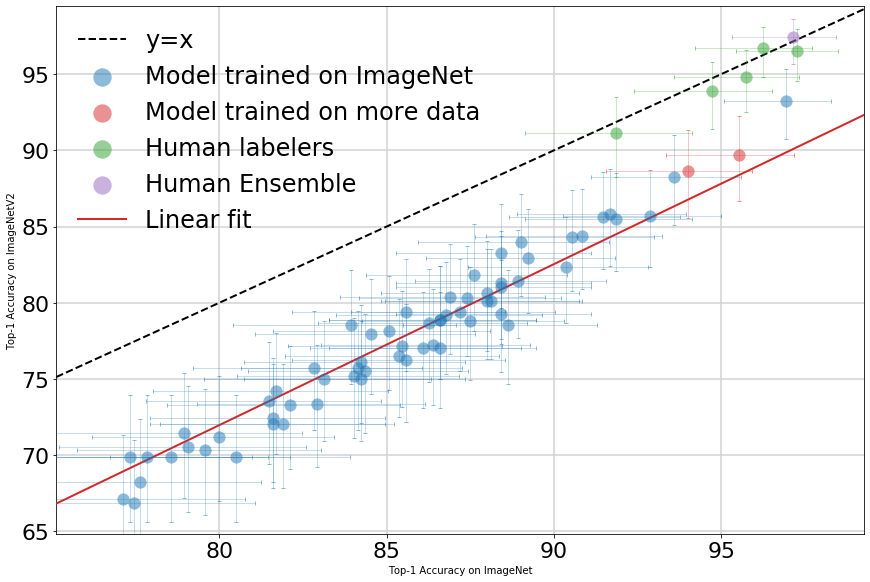

In [11]:
x_axis, y_axis = 'val', 'v2'
df1 = df.copy()
df1 = plotter.add_plotting_data(df1, [x_axis, y_axis])

# auto set xlim and ylim based on visible points
df_visible = df1[df1.show_in_plot == True]
xlim = [df_visible[x_axis].min() - 2, df_visible[x_axis].max() + 2]
ylim = [df_visible[y_axis].min() - 2, df_visible[[x_axis, y_axis]].values.max() +2]
fig, _ = plotter.model_scatter_plot(df1, x_axis, y_axis, xlim, ylim, ModelTypes, 
                                            num_bootstrap_samples=10, transform='linear', tick_multiplier=5, title = '',
                                            x_label='ImageNet', y_label='ImageNetV2', 
                                            figsize=(12, 8), include_legend=True, return_separate_legend=False)
plt.title("")
plt.xlabel("Top-1 Accuracy on ImageNet")
plt.ylabel("Top-1 Accuracy on ImageNetV2")

Include random chance:  False
ylim range / xlim range aspect ratio:  1.5007476051293316
ymax 92.58620689655173
Slope 1.0679217667433387, intercept -14.682956736943822, r 0.9861906512811747, pvalue 5.6575492054053086e-58, stderr 0.021135346593529905


AttributeError: 'Text' object has no property 'font_size'

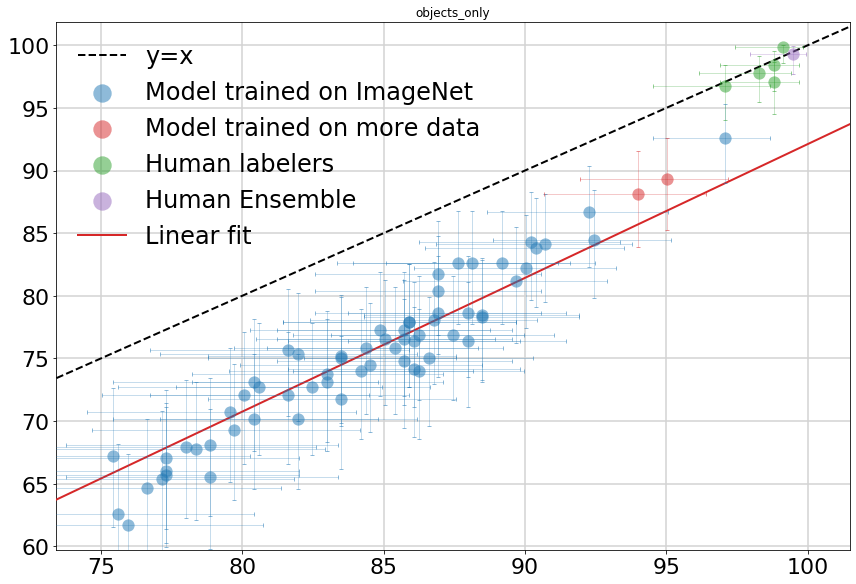

In [15]:
def subset_fig(filter_fn, fig_title):
    def filter_df_row(df_row):
        username = df_row['username']
        acc_val, num_img_filter_val = h_a.compute_accuracy(username, filters=[filter_fn, h_a.VAL_SET, h_a.NOT_PROBLEMATIC])
        acc_v2, num_img_filter_v2 = h_a.compute_accuracy(username, filters=[filter_fn, h_a.VTWO_SET, h_a.NOT_PROBLEMATIC])

        df_row['val'] = 100 * acc_val
        df_row['v2'] = 100 * acc_v2

        df_row['val_dataset_size'] = num_img_filter_val
        df_row['v2_dataset_size'] = num_img_filter_v2

        return df_row

    df_filter = df.copy()
    df_filter = df_filter.apply(filter_df_row, axis = 1)


    x_axis, y_axis = 'val', 'v2'

    df1 = plotter.add_plotting_data(df_filter, [x_axis, y_axis])

    # auto set xlim and ylim based on visible points
    df_visible = df1[df1.show_in_plot == True]
    xlim = [df_visible[x_axis].min() - 2, df_visible[x_axis].max() + 2]
    ylim = [df_visible[y_axis].min() - 2, df_visible[[x_axis, y_axis]].values.max() +2]
    fig, _ = plotter.model_scatter_plot(df1, x_axis, y_axis, xlim, ylim, ModelTypes, 
                                                num_bootstrap_samples=10, transform='linear', tick_multiplier=5,
                                                title=fig_title, x_label='ImageNet', y_label='ImageNetV2', 
                                                figsize=(12, 8), include_legend=True, return_separate_legend=False)
    plt.title(fig_title, font_size=20)
    table_users = ['human_a', 'human_b', 'human_c', 'human_d', 'human_e', 'FixResNeXt101_32x48d_v2', 
                   'instagram-48d', 'efficientnet-b7', 'resnet50']

        
subset_fig(h_a.OBJECT_FILTER, "objects_only")
subset_fig(h_a.NOTDOG_FILTER, "no_dogs")
subset_fig(h_a.FASTIMAGES_FILTER, "fast_images")

In [18]:
h_a.annot_data["human_b"]

{}